In [2]:
import pandas as pd
import datetime as dt
import re
import twint
import nest_asyncio

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt

nest_asyncio.apply()
stopwords = list(stopwords.words('russian'))

In [2]:
t = twint.Config()
t.Search = 'мцк'
t.Store_Object = True
t.Limit = None
t.Since = "2015-01-01"
t.Until = "2020-10-01"
t.Pandas = True
twint.run.Search(t)

In [6]:
mcс = twint.storage.panda.Tweets_df
mcс = mcс.loc[mcс.language == 'ru', ['date', 'tweet']]
mcс

,date,tweet
0,2020-10-01 00:06:29,Да сегодня ехала на МЦК и 70%пассажиров без ма...
1,2020-09-30 23:11:16,@stoutguinness А че на МЦК разливают уже?
2,2020-09-30 21:45:12,Прикиньте они откроют третий диаметр и первоку...
3,2020-09-30 21:03:24,"У ласточек @МЦК есть вагон тишины, где можно п..."
4,2020-09-30 20:37:51,Описываю окружность по стемневшей Москве на мцк
...,...,...
124235,2015-01-14 10:53:24,МЦК
124236,2015-01-11 15:03:47,@IvanokMagadan @AntonChudo @_todavy_ @Azhbetka...
124237,2015-01-09 05:00:56,RT ооо! @YakovGR 16 января в МЦК будет концерт...
124240,2015-01-04 06:45:30,"Сходили на Елку в МЦК, в моем детстве было все..."


In [7]:
to_match = ['@MosSobyanin', '@DtRoad', '@mosgortrans_ru', '@centralppk', '@rzd_official', '@MoscowMetro', '@MetroOperativno']

find_refs = []
for tw in mcс.tweet:
    
    tw = re.sub(',|;|:|-|\.', '', tw)
    tw = tw.split()
    
    find_refs.append(any([True if word in to_match else False for word in tw]))

mcc_refr = mcс[find_refs]

mcc_refr

,date,tweet
21,2020-09-30 14:45:38,Уровень заботы @rzd_official о пассажирах: уст...
34,2020-09-30 03:35:02,"@Oleshkevich @DtRoad Денис, видел планы по вел..."
35,2020-09-29 23:11:26,"@mosgortrans_ru Здравствуйте, Я слышал что мен..."
140,2020-09-27 19:14:27,@dcxxxiii @MoscowMetro @mosgortrans_ru @DtRoad...
156,2020-09-27 12:00:59,@traktor7 @MosSobyanin Интервал на МЦК минимум...
...,...,...
123537,2016-08-01 18:09:41,@MetroOperativno @metro_moscow @infomoscow24 н...
123538,2016-08-01 13:35:02,@atugunov @pitertransport @rzd_official Даже с...
123541,2016-08-01 02:56:26,".@DtRoad Коллеги, я преисполнен непонимания. И..."
123821,2016-07-07 15:06:17,@MetroOperativno действующий сейчас единый про...


In [8]:
mcc_refr['tweet'] = mcc_refr.tweet.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha()])
stemmer = SnowballStemmer('russian') # creating a stemmer

emo_dct = pd.read_csv('emo_dict.csv', sep=';') # importing the dictionary
emo_dct.term = emo_dct.term.apply(lambda x: stemmer.stem(x)) # stemming the dictionary

mcc_refr

<ipython-input-8-db1dd73455a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcc_refr['tweet'] = mcc_refr.tweet.apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalpha()])


,date,tweet
21,2020-09-30 14:45:38,"[уровень, заботы, о, пассажирах, установить, в..."
34,2020-09-30 03:35:02,"[oleshkevich, dtroad, денис, видел, планы, по,..."
35,2020-09-29 23:11:26,"[здравствуйте, я, слышал, что, меняются, маршр..."
140,2020-09-27 19:14:27,"[dcxxxiii, moscowmetro, dtroad, некрасовская, ..."
156,2020-09-27 12:00:59,"[mossobyanin, интервал, на, мцк, минимум, мину..."
...,...,...
123537,2016-08-01 18:09:41,"[metrooperativno, на, уже, сделали, информацию..."
123538,2016-08-01 13:35:02,"[atugunov, pitertransport, даже, слухи, ходили..."
123541,2016-08-01 02:56:26,"[dtroad, коллеги, я, преисполнен, непонимания,..."
123821,2016-07-07 15:06:17,"[metrooperativno, действующий, сейчас, единый,..."


In [9]:
def get_weights(data):
    
    a, b, c = data
    x = (b * c) / (b * c + a * c + a * b)
    y = (a * c) / (b * c + a * c + a * b)
    z = (a * b) / (b * c + a * c + a * b)
    
    return x, y, z


weights = pd.Series(get_weights(emo_dct.tag.value_counts()), index=['NEUT', 'NGTV', 'PSTV'])
weights

NEUT    0.138904
NGTV    0.345990
PSTV    0.515106
dtype: float64

In [11]:
def clean_tweet(tw):
    
    non_russian = [word for word in tw if re.match('[А-Яа-я]+', word) is None]
    
    tw = pd.Series(tw)
    tw = (tw.loc[~tw.isin(list(stopwords) + to_remove)]
          .loc[~tw.isin(set(non_russian))]
          .apply(lambda x: stemmer.stem(x))
         )
    
    return list(tw)


to_remove = ['https', 'мцд', 'twitter', 'это', 'г', 'гр', 'heart']
mcc_refr['tweet'] = mcc_refr.tweet.apply(lambda x: clean_tweet(x))

mcc_refr = mcc_refr.reset_index(drop=True)

mcc_refr

<ipython-input-11-52e840c4f612>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcc_refr['tweet'] = mcc_refr.tweet.apply(lambda x: clean_tweet(x))


,date,tweet,yy_mm
0,2020-09-30,"[уровен, забот, пассажир, установ, женск, туал...",2020-09
1,2020-09-30,"[денис, видел, план, велодорожк, рамк, мцк]",2020-09
2,2020-09-29,"[здравств, слыша, меня, маршрут, автобус, марш...",2020-09
3,2020-09-27,"[некрасовск, никуд, кладет, ткл, лп, солнцевск...",2020-09
4,2020-09-27,"[интерва, мцк, минимум, минут, как, реч, вообщ]",2020-09
...,...,...,...
1657,2016-08-01,"[сдела, информац, мцк]",2016-08
1658,2016-08-01,"[слух, ход, ласточк, мцк, перенос]",2016-08
1659,2016-08-01,"[коллег, преисполн, непониман, исправля, топон...",2016-08
1660,2016-07-07,"[действ, един, проездн, карт, тройк, работа, п...",2016-07


In [24]:
def tweet_to_words_est(date, tw, yy_mm):
    
    tw = pd.DataFrame(tw, columns=['words'])
    
    tw = (tw.merge(emo_dct, how='inner', left_on='words', right_on='term')
          .drop(['term', 'dunno', 'distortion'], axis=1)
          .drop_duplicates()
         )
    
    tw['date'] = [date for _ in range(tw.shape[0])]
    tw['yy_mm'] = [yy_mm for _ in range(tw.shape[0])]
    
    return tw


to_concat = []
for i, (date, tw, yy_mm) in enumerate(zip(mcc_refr.date, mcc_refr.tweet, mcc_refr.yy_mm)):
    
    to_concat.append(tweet_to_words_est(date, tw, yy_mm))
    
    if i % 100 == 0 and i != 0:
        print(f'{i} tweets parsed')
        
tweets_words = pd.concat(to_concat)

tweets_words

100 tweets parsed
200 tweets parsed
300 tweets parsed
400 tweets parsed
500 tweets parsed
600 tweets parsed
700 tweets parsed
800 tweets parsed
900 tweets parsed
1000 tweets parsed
1100 tweets parsed
1200 tweets parsed
1300 tweets parsed
1400 tweets parsed
1500 tweets parsed
1600 tweets parsed


,words,tag,value,pstv,neut,ngtv,date,yy_mm
0,уровен,NEUT,0.0806,0.2222,0.7037,0.0741,2020-09-30,2020-09
1,забот,PSTV,1.0000,0.8400,0.1200,0.0000,2020-09-30,2020-09
2,забот,PSTV,0.9000,0.5930,0.1977,0.0698,2020-09-30,2020-09
3,забот,PSTV,1.0000,0.8800,0.0400,0.0400,2020-09-30,2020-09
4,пассажир,NEUT,0.2241,0.2800,0.6000,0.0200,2020-09-30,2020-09
...,...,...,...,...,...,...,...,...
3,кольц,NEUT,0.0876,0.2043,0.6344,0.0645,2016-07-07,2016-07
4,технологическ,NEUT,0.3976,0.3762,0.5050,0.0594,2016-07-07,2016-07
5,технологическ,NEUT,0.5075,0.4286,0.4190,0.0667,2016-07-07,2016-07
6,поезд,NEUT,0.0000,0.1200,0.8400,0.0400,2016-07-07,2016-07


In [26]:
tweets_words.dtypes

words     object
tag       object
value    float64
pstv     float64
neut     float64
ngtv     float64
date      object
yy_mm     object
dtype: object

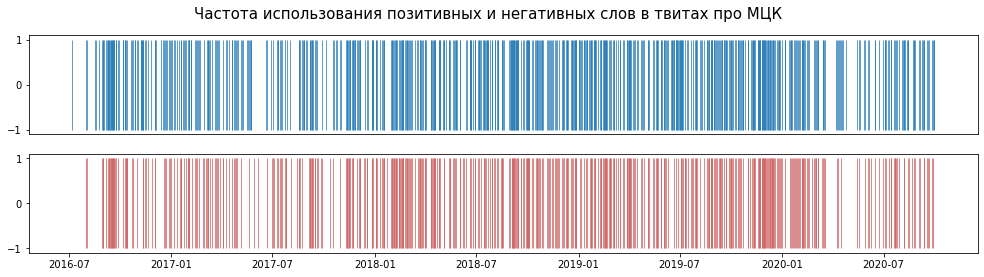

In [40]:
positive = tweets_words.groupby(['tag', 'date']).agg('count').loc['PSTV', 'words']
negative = tweets_words.groupby(['tag', 'date']).agg('count').loc['NGTV', 'words']

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 4), sharex=True)
ax1.vlines(positive.index,
           ymin=-1, ymax=1, linewidth=0.7)
ax1.tick_params(bottom=False)
ax2.vlines(negative.index,
           ymin=-1, ymax=1, color='indianred', linewidth=0.7)

f.suptitle('Частота использования позитивных и негативных слов в твитах про МЦК', fontsize=15)
# plt.savefig('intensity_mcc.png', dpi=300)
plt.show()

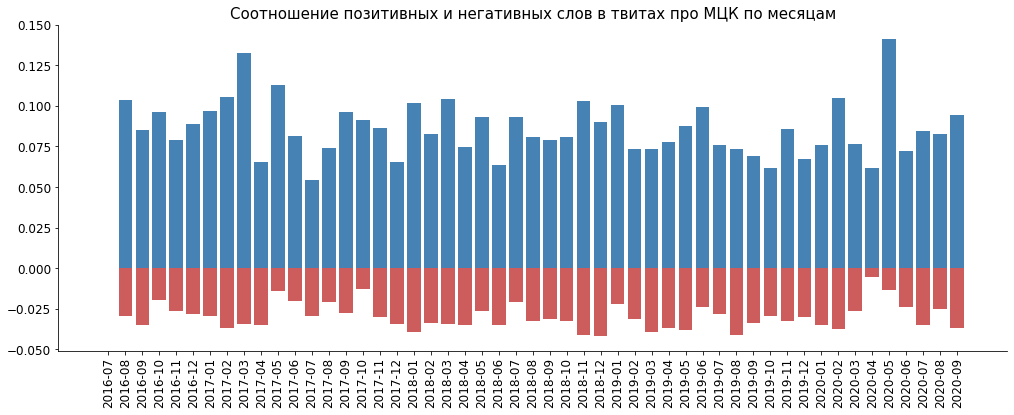

In [41]:
positive = tweets_words.groupby(['tag', 'yy_mm']).agg('count').loc['PSTV', 'words'] * weights.loc['PSTV']
negative = tweets_words.groupby(['tag', 'yy_mm']).agg('count').loc['NGTV', 'words'] * weights.loc['NGTV']
total_words_by_month = tweets_words.groupby('yy_mm').agg('count').words

date_axis = pd.date_range(tweets_words.date.min(), tweets_words.date.max(), freq='M')
date_axis = pd.Series(date_axis).apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))

for date in date_axis:
    if date not in positive:
        positive = positive.append(pd.Series('0', index=[date]))
    elif date not in negative:
        negative = negative.append(pd.Series('0', index=[date]))
        
f, ax = plt.subplots(figsize=(17, 6))
plt.bar(positive.sort_index().index, positive.sort_index().astype('int32') / total_words_by_month, color='steelblue')
plt.bar(negative.sort_index().index, (negative.sort_index().astype('int32') / total_words_by_month) * (-1), color='indianred')
ax.set_xticks(date_axis)
ax.set_xticklabels(date_axis, fontsize=12)
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('Соотношение позитивных и негативных слов в твитах про МЦК по месяцам', fontsize=15)
# plt.savefig('shares_mcc.png', dpi=300, bbox_inches='tight')
plt.show()